# CNN visualization experiments

Visualization of CNN internals: RFs, Class Activation Mapping, etc


###  Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (5,5)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

# The caffe module needs to be on the Python path;
# We added it to PYTHONPATH (e.g. from ~/.bash_profile)

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

### Loading the model & setting up caffe

We will use the model from https://github.com/metalbubble/CAM 

In [2]:
# We'll need to download the model weights
# Make sure you run this script to download the model weights file
# experiments/visualization/CAM/models/download.sh

In [3]:
cam_path = 'visualization/CAM'
model_definition = cam_path + '/models/deploy_googlenetCAM.prototxt'
model_weights    = cam_path + '/models/imagenet_googleletCAM_train_iter_120000.caffemodel'

caffe.set_mode_gpu()
net = caffe.Net(model_definition,
         model_weights,
         caffe.TEST)
print 'Net model sucessfully loaded'

Net model sucessfully loaded


In [4]:
# load the mean places image 
mu = np.load('Emotion6/places205CNN_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.92972906422801), ('G', 113.25471068604384), ('R', 116.20969209889881)]


### Classifying images in the test set

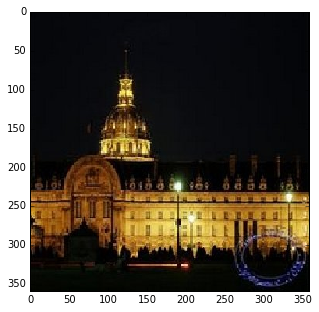

In [5]:
def classify_image(image_file):
    image = caffe.io.load_image(image_file)
    net.blobs['data'].data[...] = transformer.preprocess('data', image)
    # perform classification
    net.forward()
    
def show_image(image_file):
    image = caffe.io.load_image(image_file)
    plt.imshow(image)
    plt.show()

sample_image = 'visualization/CAM/img2.jpg'
show_image(sample_image)

In [6]:
classify_image(sample_image)

conv_blobs    = net.blobs['CAM_conv'].data[0]
weight_matrix = net.params['CAM_fc'][0].data
net_output    = net.blobs['prob'].data[0]


Class no. 698 Activation Mapping


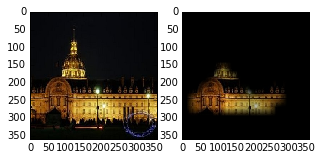

Class no. 538 Activation Mapping


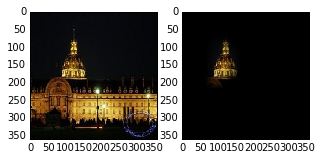

Class no. 873 Activation Mapping


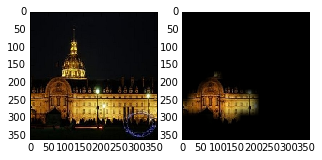

Class no. 497 Activation Mapping


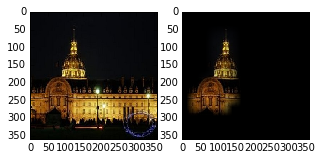

Class no. 406 Activation Mapping


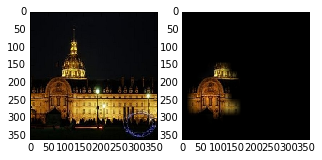

In [7]:
def weights_for_class(class_idx):
    return weight_matrix[class_idx,:]

c = conv_blobs.reshape([conv_blobs.shape[0], conv_blobs.shape[1]*conv_blobs.shape[2]])    

import scipy

def show_CAM(img, idx):
    w = weights_for_class(idx)
    CAM = c.transpose().dot(w)
    print 'Class no. %i Activation Mapping' % idx
    mask = CAM.reshape(14,14)
    threshold = 0.5*mask.max()
    mask[mask < threshold] = 0
    mask = scipy.misc.imresize(mask,img.shape[:2])     
    masked = img * mask[:,:,None]
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img)
    axarr[1].imshow(masked/masked.max())
    plt.show()

top5_ids = np.argsort(net_output)[-5:][::-1]
image = caffe.io.load_image(sample_image)

for class_id in top5_ids:
    show_CAM(image, class_id)
    plt.show()


Next steps:

- Finetuning of the CAM nets to work with thresholded valendce annotations 
- Training with the new database (IAPS)
- Finetune a NiN model and examine the inner convolutional layers' outputs. Do they retain semantic information?
- Localization:
    - Choose a database (or databases) with object (localization) annotations (maybe MS COCO) 
    - Create positive and negative samples: positives contain the objects of interest, negatives do not contain objects.
    - Train a 2-class classifier.
    - Analyze the CAM output. Does it contain localization information?
    - Plan B: analyze the RF output of the conv layers and relate it to object O location.
- How do RFs evolve during fine tuning?